I will try to plot a filed that is smoothed in two ways: in one we set negative EVI to zero to show why we are doing it, and in another one we do not

In [1]:
# import warnings
# warnings.filterwarnings("ignore")

import csv
import numpy as np
import pandas as pd
# import geopandas as gpd
from IPython.display import Image
# from shapely.geometry import Point, Polygon
from math import factorial
import scipy
import scipy.signal
import os, os.path

from datetime import date
import datetime
import time

from statsmodels.sandbox.regression.predstd import wls_prediction_std
from sklearn.linear_model import LinearRegression
from patsy import cr

# from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sb

import sys

/Users/hn/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
sys.path.append('/Users/hn/Documents/00_GitHub/Ag/remote_sensing/python/')
import remote_sensing_core as rc
import remote_sensing_plot_core as rcp

start_time = time.time()

In [3]:
data_dir = "/Users/hn/Documents/01_research_data/" + \
           "remote_sensing/01_NDVI_TS/70_Cloud/00_Eastern_WA_withYear/2Years/"

param_dir = "/Users/hn/Documents/00_GitHub/Ag/remote_sensing/parameters/"

In [4]:
####################################################################################
###
###      Parameters                   
###
####################################################################################

SF_year = 2017
indeks = "EVI"

In [5]:
# f_name = "Eastern_WA_" + str(SF_year) + "_70cloud_selectors.csv"
# a_df = pd.read_csv(data_dir + f_name, low_memory=False)

# desired_ID = "41876_WSDA_SF_2017"
# a_df = a_df[a_df.ID == desired_ID] # Filter Grant
# a_df['SF_year'] = SF_year

In [6]:
write_dir = "/Users/hn/Documents/01_research_data/remote_sensing/data_for_plots_in_paper/"
# a_df.to_csv(write_dir + "negative_EVI_ratio_showCase.csv", index = False)

In [7]:
a_df = pd.read_csv(write_dir + "negative_EVI_ratio_showCase.csv", low_memory=False)

In [8]:
one_field = a_df.copy()
one_field.sort_values(by=['image_year', 'doy'], inplace=True)

In [9]:
one_field.reset_index(drop=True, inplace=True)
one_field = one_field[one_field['EVI'].notna()]

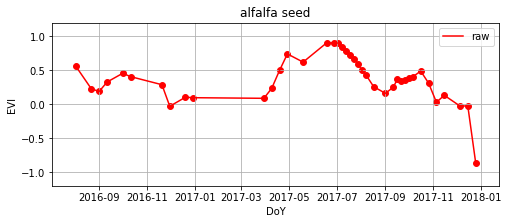

In [10]:
one_field['human_system_start_time'] = pd.to_datetime(one_field['image_year'] * 1000 + \
                                                      one_field['doy'], format='%Y%j')

one_field['Date'] = pd.to_datetime(one_field.human_system_start_time.values).values

fig, ax = plt.subplots(figsize=(8,3));
plot_title = one_field.CropTyp.unique()[0]

ax.plot(one_field['Date'], one_field['EVI'], c='r', label="raw")
ax.scatter(one_field['Date'], one_field['EVI'], marker='o', s=35, c='r')
ax.set_ylim([-1.2, 1.2])

ax.set_title(plot_title);
ax.set(xlabel='DoY', ylabel='EVI')
ax.legend(loc="best");
ax.grid(True)

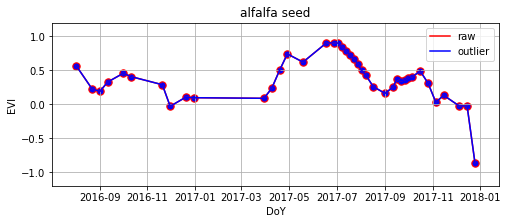

In [11]:
cleaned_field = rc.interpolate_outliers_EVI_NDVI(outlier_input = one_field , given_col = indeks)
fig, ax = plt.subplots(figsize=(8,3));
plot_title = cleaned_field.CropTyp.unique()[0]


ax.plot(one_field['Date'], one_field['EVI'], c='r', label="raw")
ax.scatter(one_field['Date'], one_field['EVI'], marker='o', s=55, c='r')

ax.plot(cleaned_field['Date'], cleaned_field['EVI'], c='b', label="outlier")
ax.scatter(cleaned_field['Date'], cleaned_field['EVI'], marker='o', s=25, c='b')

ax.set_ylim([-1.2, 1.2])

ax.set_title(plot_title);
ax.set(xlabel='DoY', ylabel='EVI')
ax.legend(loc="best");
ax.grid(True)

In [12]:
outlierRemoved_EVI_values = cleaned_field['EVI']
outlierRemoved_EVI_time = cleaned_field['Date']

In [13]:
cleaned_field = rc.correct_big_jumps_1DaySeries(dataTMS_jumpie = cleaned_field, 
                                                give_col = indeks, 
                                                maxjump_perDay = 0.015)

In [14]:
outlierJumpRemoved_EVI_values = cleaned_field['EVI']
outlierJumpRemoved_EVI_time = cleaned_field['Date']

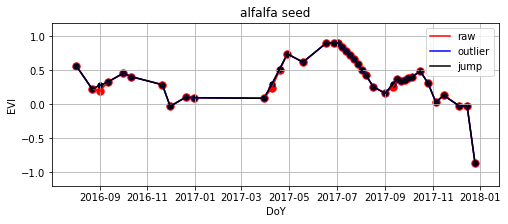

In [15]:
fig, ax = plt.subplots(figsize=(8,3));
plot_title = cleaned_field.CropTyp.unique()[0]

ax.plot(one_field['Date'], one_field['EVI'], c='r', label="raw")
ax.scatter(one_field['Date'], one_field['EVI'], marker='o', s=55, c='r')

ax.plot(cleaned_field['Date'], cleaned_field['EVI'], c='b', label="outlier and jump removed")
ax.scatter(cleaned_field['Date'], cleaned_field['EVI'], marker='o', s=25, c='b')

ax.set_ylim([-1.2, 1.2])

ax.set_title(plot_title);
ax.set(xlabel='DoY', ylabel='EVI')
ax.legend(loc="best");
ax.grid(True)

In [16]:
save_for_True_False = cleaned_field.copy()

In [29]:
negative_to_zero = False
cleaned_field = save_for_True_False.copy()
if negative_to_zero == True:
    cleaned_field.loc[cleaned_field[indeks] < 0, indeks] = 0
    

In [30]:
min(cleaned_field.EVI)

-0.8573123862516655

In [31]:
# regularize
regular_window_size = 10 
regularized_TS = rc.regularize_movingWindow_windowSteps_2Yrs(one_field_df = cleaned_field, \
                                                             SF_yr = SF_year, \
                                                             veg_idxs = indeks, \
                                                             window_size = regular_window_size)

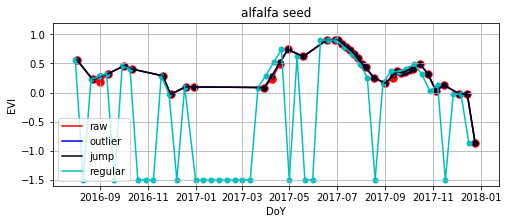

In [32]:
regularized_TS['human_system_start_time'] = pd.to_datetime(regularized_TS['image_year'] * 1000 + \
                                                           regularized_TS['doy'], format='%Y%j')

regularized_TS['Date'] = pd.to_datetime(regularized_TS.human_system_start_time.values).values


fig, ax = plt.subplots(figsize=(8,3));
plot_title = regularized_TS.CropTyp.unique()[0]

ax.plot(one_field['Date'], one_field['EVI'], c='r', label="raw")
ax.scatter(one_field['Date'], one_field['EVI'], marker='o', s=55, c='r')

ax.plot(cleaned_field['Date'], cleaned_field['EVI'], c='b', label="outlier")
ax.scatter(cleaned_field['Date'], cleaned_field['EVI'], marker='o', s=25, c='b')

ax.plot(cleaned_field['Date'], cleaned_field['EVI'], c = 'k', label="jump")
ax.scatter(cleaned_field['Date'], cleaned_field['EVI'], marker='o', s=25, c='k')

ax.plot(regularized_TS['Date'], regularized_TS['EVI'], c = 'c', label="regular")
ax.scatter(regularized_TS['Date'], regularized_TS['EVI'], marker='o', s=25, c='c')

ax.set_ylim([-1.6, 1.2])

ax.set_title(plot_title);
ax.set(xlabel='DoY', ylabel='EVI')
ax.legend(loc="best");
ax.grid(True)

In [33]:
regularized_EVI_values = regularized_TS['EVI']
regularized_EVI_time = regularized_TS['Date']

In [34]:
regularized_TS = rc.fill_theGap_linearLine(regular_TS = regularized_TS, V_idx = indeks, SF_year = 2017)

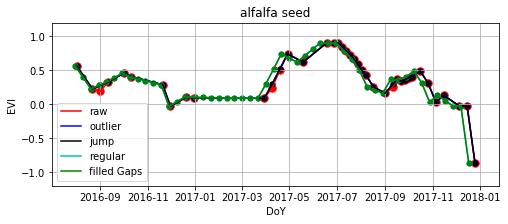

In [35]:
regularized_TS['human_system_start_time'] = pd.to_datetime(regularized_TS['image_year'] * 1000 + \
                                                           regularized_TS['doy'], format='%Y%j')

regularized_TS['Date'] = pd.to_datetime(regularized_TS.human_system_start_time.values).values


fig, ax = plt.subplots(figsize=(8,3));
plot_title = regularized_TS.CropTyp.unique()[0]


ax.plot(one_field['Date'], one_field['EVI'], c='r', label="raw")
ax.scatter(one_field['Date'], one_field['EVI'], marker='o', s=55, c='r')

ax.plot(cleaned_field['Date'], cleaned_field['EVI'], c='b', label="outlier")
ax.scatter(cleaned_field['Date'], cleaned_field['EVI'], marker='o', s=25, c='b')

ax.plot(cleaned_field['Date'], cleaned_field['EVI'], c = 'k', label="jump")
ax.scatter(cleaned_field['Date'], cleaned_field['EVI'], marker='o', s=25, c='k')

ax.plot(regularized_TS['Date'], regularized_TS['EVI'], c = 'c', label="regular")
ax.scatter(regularized_TS['Date'], regularized_TS['EVI'], marker='o', s=25, c='c')


ax.plot(regularized_TS['Date'], regularized_TS['EVI'], c = 'g', label="filled Gaps")
ax.scatter(regularized_TS['Date'], regularized_TS['EVI'], marker='o', s=25, c='g')

ax.set_title(plot_title);
ax.set(xlabel='DoY', ylabel='EVI')
ax.legend(loc="best");
ax.set_ylim([-1.2, 1.2])
ax.grid(True)

In [36]:
filledGaps_EVI_values = regularized_TS['EVI']
filledGaps_EVI_time = regularized_TS['Date']

In [37]:
clean_regularized_TS = regularized_TS

In [38]:
def SG_1yr_panels_noPeak_SOS_fineGranularity(twoYears_raw, 
                                             twoYears_regular, 
                                             idx, SG_params, SFYr, ax, deltA = 0.4, 
                                             onset_cut=0.5, offset_cut=0.5):
    """
    This function has additional part to plot SOS and EOS.
    and it is updated version of the function savitzky_1yr_panels_clean_sciPy_and_My_PeakFinder(.)
    """
    ## crr_fld = dataAB.copy() #***
    crr_fld_twoYrs_regular = twoYears_regular.copy() #***
    if (not("human_system_start_time" in list(crr_fld_twoYrs_regular.columns))):
        crr_fld_twoYrs_regular = rc.add_human_start_time(crr_fld_twoYrs_regular)

    eleven_colors = ["gray", "lightcoral", "red", "peru",
                     "darkorange", "gold", "olive", "green",
                     "blue", "violet", "deepskyblue"]

    plant = crr_fld_twoYrs_regular['CropTyp'].unique()[0]
    #
    # Take care of names, replace "/" and "," and " " by "_"
    #
    plant = plant.replace("/", "_")
    plant = plant.replace(",", "_")
    plant = plant.replace(" ", "_")
    plant = plant.replace("__", "_")

    county = crr_fld_twoYrs_regular['county'].unique()[0]
    ID = crr_fld_twoYrs_regular['ID'].unique()[0]
    ###
    ### Copy the regularized values that are processed up to SG smoothing.
    ###
    twoYrs_regular_Yvalues = crr_fld_twoYrs_regular[idx].copy()
    twoYrs_regular_Xvalues = crr_fld_twoYrs_regular['Date'].copy()

    crr_fld_twoYrs_regular_1Year = crr_fld_twoYrs_regular.copy()
    crr_fld_twoYrs_regular_1Year = crr_fld_twoYrs_regular_1Year[crr_fld_twoYrs_regular_1Year.image_year >= SFYr]
    twoYrs_regular_Yvalues_1Year = crr_fld_twoYrs_regular_1Year[idx].copy()
    twoYrs_regular_Xvalues_1Year = crr_fld_twoYrs_regular_1Year['Date'].copy()

    #############################################
    ###
    ###             Smoothen
    ###
    #############################################
    # differences are minor, but lets keep using Pythons function
    # my_savitzky_pred = rc.savitzky_golay(y, window_size=Sav_win_size, order=sav_order)
    window_len = SG_params[0]
    poly_order = SG_params[1]

    ## SG_pred = scipy.signal.savgol_filter(y, window_length= window_len, polyorder=poly_order) #***

    SG_pred_twoYears = scipy.signal.savgol_filter(twoYrs_regular_Yvalues, 
                                                  window_length= window_len, 
                                                  polyorder=poly_order)

    # SG might violate the boundaries. clip them:
    SG_pred_twoYears[SG_pred_twoYears > 1 ] = 1
    SG_pred_twoYears[SG_pred_twoYears < -1 ] = -1
    
    crr_fld_twoYrs_regular[idx] = SG_pred_twoYears
    
    # crr_fld will be one year from now on
    crr_fld = crr_fld_twoYrs_regular.copy()
    crr_fld = crr_fld[crr_fld.image_year == SFYr]
    #############################################
    ###
    ###             fine granularity table
    ###
    #############################################
    # create the full calenadr to make better estimation of SOS and EOS.
    fine_granular_table = rc.create_calendar_table(SF_year = SFYr)
    fine_granular_table = pd.merge(fine_granular_table, crr_fld, on=['Date', 'SF_year', 'doy'], how='left')

    ###### We need to fill the NAs that are created because they were not created in fine_granular_table
    fine_granular_table["image_year"] = crr_fld["image_year"].unique()[0]
    fine_granular_table["ID"]     = crr_fld["ID"].unique()[0]

    fine_granular_table = rc.add_human_start_time_by_YearDoY(fine_granular_table)

    # replace NAs with -1.5. Because, that is what the function fill_theGap_linearLine()
    # uses as indicator for missing values
    fine_granular_table.fillna(value={idx:-1.5}, inplace=True)
    
    fine_granular_table = rc.fill_theGap_linearLine(regular_TS = fine_granular_table, 
                                                    V_idx=idx, 
                                                    SF_year=SFYr)
    
    # update SG_pred so that we do not have to update too many other stuff.
    SG_pred = fine_granular_table[idx].values.copy()
    crr_fld = fine_granular_table
    y = fine_granular_table[idx].copy()
    #############################################
    ###
    ###   Form a data table of X and Y values
    ###
    #############################################

    if len(fine_granular_table['image_year'].unique()) == 2:
        X = rc.extract_XValues_of_2Yrs_TS(fine_granular_table, SF_yr = SFYr)
    elif len(fine_granular_table['image_year'].unique()) == 1:
        X = fine_granular_table['doy']

    d = {'DoY': X, 'Date': pd.to_datetime(fine_granular_table.human_system_start_time.values).values}
    date_df = pd.DataFrame(data=d)

    #############################################
    ###
    ###             plot
    ###
    #############################################
    plant.replace("_", " ")
    ax.set_ylim([-1.15, 1.15])

    ###
    ###   plot SOS and EOS
    ###
    # Update the EVI/NDVI values to the smoothed version.
    crr_fld [idx] = SG_pred
    crr_fld = rc.addToDF_SOS_EOS_White(pd_TS = crr_fld, 
                                       VegIdx = idx, 
                                       onset_thresh = onset_cut, 
                                       offset_thresh = offset_cut)
   
    crr_fld = rc.Null_SOS_EOS_by_DoYDiff(pd_TS = crr_fld, min_season_length=40)
    
    # Plot ratios:
    crr_fld = crr_fld[crr_fld.Date >= pd.Timestamp(year=SFYr, month=1, day=1)]
    ax.plot(crr_fld['Date'], crr_fld['EVI_ratio'], c='gray', label="EVI Ratio")

    ax.scatter(date_df.Date.values, y.values, label="1-Day Time Series", s=7, c='b');
    # plot SG smoothed version of two years
    keyy = "SG: [" + str(window_len) + ", " + str(poly_order) + "]"
    crr_fld_twoYrs_regular = crr_fld_twoYrs_regular[crr_fld_twoYrs_regular.image_year >= SFYr]
    ax.plot(crr_fld_twoYrs_regular['Date'].values, crr_fld_twoYrs_regular[idx], label= keyy, c='k');

    SOS = crr_fld[crr_fld['SOS'] != 0]
    ax.scatter(SOS['Date'], SOS['SOS'], marker='+', s=155, c='g')

    EOS = crr_fld[crr_fld['EOS'] != 0]
    ax.scatter(EOS['Date'], EOS['EOS'], marker='+', s=155, c='r')
    
    # plot regularized version of two years
    ax.scatter(twoYrs_regular_Xvalues_1Year.values, twoYrs_regular_Yvalues_1Year, 
               label="process. data", s=7, c='#E4D00A');

    # plot raw data of two years
    twoYears_raw = twoYears_raw[twoYears_raw.image_year >= SFYr]
    ax.scatter(twoYears_raw['Date'].values, twoYears_raw[idx], label="raw data", s=7, c='dodgerblue');

    ax.set_title(plot_title);
    ax.set(ylabel=idx)
    ax.legend(loc="best");

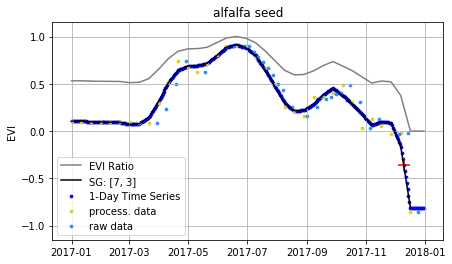

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(7, 4),
                        sharex='col', sharey='row',
                        gridspec_kw={'hspace': 0.1, 'wspace': .1});
ax.grid(True)

rcp.SG_1yr_panels_noPeak_SOS_fineGranularity(twoYears_raw = one_field,
                                         twoYears_regular = clean_regularized_TS, 
                                         idx=indeks, 
                                         SG_params=[7, 3], 
                                         SFYr=SF_year, 
                                         ax=ax,
                                         onset_cut=0.3, offset_cut=0.3);


plot_path = "/Users/hn/Documents/00_GitHub/Ag_papers/remote_sensing/plots_for_paper/"
plant = clean_regularized_TS.CropTyp.unique()[0]
county = clean_regularized_TS.county.unique()[0]
ID = clean_regularized_TS.ID.unique()[0]

if negative_to_zero == True:
    fig_name = plot_path + county + "_" + plant + "_SF_year_" + str(SF_year) + "_" + ID + '_set_zero.png'
else:
    fig_name = plot_path + county + "_" + plant + "_SF_year_" + str(SF_year) + "_" + ID + '.png'

plt.savefig(fname = fig_name, dpi=600, bbox_inches='tight')